# Project: Wrangling and Analyze Data

In [1]:
import numpy as np
import pandas as pd
import os
import requests
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
twitter_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
twitter_enhanced.query('name == "Tilly"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [6]:
twitter_enhanced.name.nunique()

957

In [7]:
twitter_enhanced.name.value_counts()

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
Sadie           8
the             8
Bailey          7
Daisy           7
an              7
Toby            7
Buddy           7
Milo            6
Rusty           6
Jax             6
Koda            6
Leo             6
Jack            6
Bella           6
Oscar           6
Dave            6
Scout           6
Stanley         6
very            5
             ... 
Noah            1
Teddy           1
Godzilla        1
Rufio           1
Wesley          1
Wiggles         1
Lulu            1
Tess            1
Zooey           1
Bert            1
officially      1
Kollin          1
Mitch           1
Shadoe          1
Heinrich        1
life            1
Rose            1
Mimosa          1
Nida            1
Holly           1
Pherb           1
Jett            1
Schnitzel       1
Daniel          1
Kial      

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [8]:
tweet_image_request = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv")

In [9]:
print(tweet_image_request) # Checking that the response is good

<Response [200]>


In [10]:
# writing the "image_predictions.csv" file
with open("image_predictions.csv", mode = 'wb') as file:
    file.write(tweet_image_request.content)

In [11]:
df_image_predictions = pd.read_csv('image_predictions.csv', sep='\t')

In [12]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
df_image_predictions.query('p1_dog == False').sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
364,672884426393653248,https://pbs.twimg.com/media/CVaQ0M4UsAAki3t.jpg,1,tusker,0.122410,False,warthog,0.119870,False,water_buffalo,0.105856,False
943,704347321748819968,https://pbs.twimg.com/media/CcZYJniXEAAEJRF.jpg,1,teddy,0.233378,False,feather_boa,0.088474,False,Brittany_spaniel,0.082917,True
1335,758041019896193024,https://pbs.twimg.com/media/CoUaSKEXYAAYsAl.jpg,1,bookshop,0.794272,False,Cardigan,0.051265,True,Bernese_mountain_dog,0.026596,True
1672,813112105746448384,https://pbs.twimg.com/media/C0jBJZVWQAA2_-X.jpg,1,dingo,0.287369,False,Pembroke,0.140682,True,basenji,0.090819,True
199,669661792646373376,https://pbs.twimg.com/media/CUsd2TfWwAAmdjb.jpg,1,weasel,0.262802,False,Siamese_cat,0.148263,False,hamster,0.116374,False
1711,818536468981415936,https://pbs.twimg.com/media/C1wGkYoVQAAuC_O.jpg,1,swing,0.999403,False,Welsh_springer_spaniel,0.000062,True,bow,0.000030,False
1005,709042156699303936,https://pbs.twimg.com/media/CdcGBB3WwAAGBuU.jpg,1,hotdog,0.826579,False,Rottweiler,0.068179,True,Labrador_retriever,0.049218,True
761,688894073864884227,https://pbs.twimg.com/media/CY9xf1dUAAE4XLc.jpg,1,hog,0.669996,False,guinea_pig,0.077347,False,hamster,0.062398,False
235,670427002554466305,https://pbs.twimg.com/media/CU3VzVwWwAAAsst.jpg,1,seat_belt,0.952258,False,toy_terrier,0.038872,True,beagle,0.003226,True
1195,740365076218183684,https://pbs.twimg.com/media/CkZOGhJWsAAHvPv.jpg,1,bow_tie,0.246313,False,Windsor_tie,0.172446,False,mushroom,0.137516,False


In [14]:
df_image_predictions.query('p1_dog == False or p2_dog == False or p3_dog == False').count()[0]

832

In [15]:
df_image_predictions.query('p1_dog == False').count()[0]

543

In [16]:
df_image_predictions.query('p2_dog == False').count()[0]

522

In [17]:
df_image_predictions.query('p3_dog == False').count()[0]

576

In [18]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

### Reference
https://knowledge.udacity.com/questions/94203

In [19]:
selected_attr = []

with open('tweet-json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        selected_attr.append({'tweet_id':json_data['id_str'],
                              'retweet_status':json_data['retweeted'],
                              'retweets': json_data['retweet_count'],
                              'favourites':json_data['favorite_count']
        }
        )

tweet_json = pd.DataFrame(selected_attr, columns = ['tweet_id',
                                                   'retweet_status',
                                                   'retweets',
                                                   'favourites'])

In [20]:
tweet_json.head()

,tweet_id,retweet_status,retweets,favourites
0,892420643555336193,False,8853,39467
1,892177421306343426,False,6514,33819
2,891815181378084864,False,4328,25461
3,891689557279858688,False,8964,42908
4,891327558926688256,False,9774,41048


In [21]:
tweet_json.query('retweet_status == False').count()

tweet_id          2354
retweet_status    2354
retweets          2354
favourites        2354
dtype: int64

In [22]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null object
retweet_status    2354 non-null bool
retweets          2354 non-null int64
favourites        2354 non-null int64
dtypes: bool(1), int64(2), object(1)
memory usage: 57.5+ KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Quality issues

#### 'twitter-archive-enhanced.csv'
1. Ignoring retweets by keeping twitter_enhanced, retweeted_status_id == NaN

1. One url is enough instead of two

2. Timestamp is an object instead of type date time

3. 745 names are None and articles a, an, the are used as dog's name. Dropping the name column

#### 'image-predictions.csv'

5. 832 are not dogs. 543 p1_dog are not dogs

6. Dropping the img_num column

#### 'tweet-json.txt'

7. Selecting only the necessary columns from tweet_id, retweet_status, retweets, favourites


8. Convert the id type from int to string in 'twitter-archive-enhanced.csv' and 'image-predictions.csv'


### Tidiness issues
1. In 'twitter-archive-enhanced' values (doggo, floofer, pupper, puppo) are stored as variable

2. In 'twitter-archive-enhanced' creating a new field. rating = rating_numerator / rating_denominator. In some cases rating_denominator is more than 10. Rating denominator is not a constant.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [23]:
# Make copies of original pieces of data
twitter_enhanced_clean = twitter_enhanced.copy()

In [24]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [25]:
image_predictions_clean = df_image_predictions.copy()


In [26]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [27]:
tweet_json_clean = tweet_json.copy()

In [28]:
tweet_json_clean.head()

,tweet_id,retweet_status,retweets,favourites
0,892420643555336193,False,8853,39467
1,892177421306343426,False,6514,33819
2,891815181378084864,False,4328,25461
3,891689557279858688,False,8964,42908
4,891327558926688256,False,9774,41048


### Issue #1:

#### Define: 

Ignoring retweets by keeping twitter_enhanced, retweeted_status_id == NaN

#### Code

In [29]:
twitter_enhanced_clean.query('retweeted_status_id != "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [30]:
twitter_enhanced_clean.query('retweeted_status_id != "NaN"').count()[0]

181

In [31]:
twitter_enhanced_clean.retweeted_status_id.value_counts()

7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
8.780576e+17    1
7.320056e+17    1
7.186315e+17    1
6.732953e+17    1
7.914070e+17    1
8.447048e+17    1
7.862340e+17    1
8.685523e+17    1
7.504293e+17    1
8.327664e+17    1
6.690004e+17    1
6.873173e+17    1
7.638376e+17    1
7.815247e+17    1
8.092201e+17    1
8.000650e+17    1
8.174239e+17    1
8.001414e+17    1
7.909461e+17    1
7.867091e+17    1
8.406323e+17    1
8.688804e+17    1
7.869631e+17    1
7.733088e+17    1
8.222448e+17    1
               ..
6.816941e+17    1
7.899865e+17    1
7.939622e+17    1
6.800555e+17    1
7.128090e+17    1
8.164506e+17    1
6.769365e+17    1
6.675487e+17    1
8.083449e+17    1
7.626999e+17    1
6.678667e+17    1
8.479710e+17    1
6.820881e+17    1
8.352641e+17    1
7.761133e+17    1
7.902771e+17    1
6.675484e+17    1
7.677549e+17    1
8.782815e+17    1
8.663350e+17    1
7.399792e+17    1
7.403732e+17    1
8.395493e+17    1
7.001438e+17    1
8.482894e+

In [32]:
twitter_enhanced_clean = twitter_enhanced_clean[twitter_enhanced_clean['retweeted_status_id'].isna()]

#### Test

In [33]:
twitter_enhanced.shape

(2356, 17)

In [34]:
twitter_enhanced_clean.shape

(2175, 17)

In [35]:
2356 - 181

2175

### Issue #2:

#### Define

One url is enough instead of two

#### Code

In [36]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [37]:
## Removing the source but keeping the 'expanded_urls'

In [38]:
twitter_enhanced_clean = twitter_enhanced_clean.drop('source', axis=1)

#### Test

In [39]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue 3

#### Define

Timestamp is an object instead of type date time

#### Code

In [40]:
twitter_enhanced_clean['timestamp'] = pd.to_datetime(twitter_enhanced_clean['timestamp'])

#### Test

In [41]:
twitter_enhanced_clean.timestamp.head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

### Issue 4

#### Define

745 names are None and articles a, an, the are used as dog's name. Dropping the name column

#### Code

In [42]:
twitter_enhanced_clean = twitter_enhanced_clean.drop('name', axis = 1)

#### Test

In [43]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None


In [44]:
twitter_enhanced_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue 5

#### Define

832 are not dogs. 543 p1_dog are not dogs

#### Code

In [45]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [46]:
image_predictions_clean.query('p1_dog == False').count()[0]

543

In [47]:
image_predictions_clean.query('p1_dog == False or p2_dog == False or p3_dog == False').count()[0]

832

In [48]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [49]:
image_predictions_clean.shape

(2075, 12)

In [50]:
image_predictions_clean.query('p1_dog == True and p2_dog == True and p3_dog == True').count()[0]

1243

In [51]:
2075 - 1243

832

In [52]:
image_predictions_clean.query('p1_dog == True and p2_dog == True and p3_dog == True').head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [53]:
image_predictions_clean.query('p1_dog == True and p2_dog == True and p3_dog == True').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1243 non-null int64
jpg_url     1243 non-null object
img_num     1243 non-null int64
p1          1243 non-null object
p1_conf     1243 non-null float64
p1_dog      1243 non-null bool
p2          1243 non-null object
p2_conf     1243 non-null float64
p2_dog      1243 non-null bool
p3          1243 non-null object
p3_conf     1243 non-null float64
p3_dog      1243 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 100.8+ KB


#### Test

In [54]:
image_predictions_clean = image_predictions_clean.query('p1_dog == True and p2_dog == True and p3_dog == True')

In [55]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1243 non-null int64
jpg_url     1243 non-null object
img_num     1243 non-null int64
p1          1243 non-null object
p1_conf     1243 non-null float64
p1_dog      1243 non-null bool
p2          1243 non-null object
p2_conf     1243 non-null float64
p2_dog      1243 non-null bool
p3          1243 non-null object
p3_conf     1243 non-null float64
p3_dog      1243 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 100.8+ KB


### Issue 6

#### Define

Dropping the img_num column

#### Code

In [56]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [57]:
image_predictions_clean = image_predictions_clean.drop('img_num', axis=1)

#### Test

In [58]:
image_predictions_clean.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue 7

#### Define

Selecting only the necessary columns from tweet_id, retweet_status, retweets, favourites

#### Code

In [59]:
## Have already selected the necessary columns
tweet_json_clean.head()

,tweet_id,retweet_status,retweets,favourites
0,892420643555336193,False,8853,39467
1,892177421306343426,False,6514,33819
2,891815181378084864,False,4328,25461
3,891689557279858688,False,8964,42908
4,891327558926688256,False,9774,41048


#### Test

In [60]:
tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null object
retweet_status    2354 non-null bool
retweets          2354 non-null int64
favourites        2354 non-null int64
dtypes: bool(1), int64(2), object(1)
memory usage: 57.5+ KB


### Issue 8

#### Define

Convert the id type from int to string in 'twitter-archive-enhanced.csv' and 'image-predictions.csv'

#### Code

In [61]:
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 271.9+ KB


In [62]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 11 columns):
tweet_id    1243 non-null int64
jpg_url     1243 non-null object
p1          1243 non-null object
p1_conf     1243 non-null float64
p1_dog      1243 non-null bool
p2          1243 non-null object
p2_conf     1243 non-null float64
p2_dog      1243 non-null bool
p3          1243 non-null object
p3_conf     1243 non-null float64
p3_dog      1243 non-null bool
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 91.0+ KB


In [63]:
twitter_enhanced_clean['tweet_id'] = twitter_enhanced_clean['tweet_id'].astype(str)

In [64]:
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

#### Test

In [65]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None


In [66]:
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(8)
memory usage: 271.9+ KB


In [67]:
image_predictions_clean.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [68]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 11 columns):
tweet_id    1243 non-null object
jpg_url     1243 non-null object
p1          1243 non-null object
p1_conf     1243 non-null float64
p1_dog      1243 non-null bool
p2          1243 non-null object
p2_conf     1243 non-null float64
p2_dog      1243 non-null bool
p3          1243 non-null object
p3_conf     1243 non-null float64
p3_dog      1243 non-null bool
dtypes: bool(3), float64(3), object(5)
memory usage: 91.0+ KB


In [69]:
image_predictions_clean.p1.value_counts()

golden_retriever                  126
Pembroke                           78
Labrador_retriever                 77
Chihuahua                          54
pug                                41
Pomeranian                         28
toy_poodle                         27
chow                               27
Samoyed                            27
malamute                           26
cocker_spaniel                     25
miniature_pinscher                 21
French_bulldog                     20
beagle                             18
German_shepherd                    17
Siberian_husky                     17
Staffordshire_bullterrier          17
Cardigan                           16
Shih-Tzu                           15
Maltese_dog                        15
Rottweiler                         15
Chesapeake_Bay_retriever           15
Shetland_sheepdog                  15
Eskimo_dog                         14
Lakeland_terrier                   14
Italian_greyhound                  13
American_Sta

### Issue 9 : Tidiness Issue

#### Define

In 'twitter-archive-enhanced' values (doggo, floofer, pupper, puppo) are stored as variable

#### Code

In [70]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None


In [71]:
twitter_enhanced_clean['dog_stages'] = twitter_enhanced_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand= True)

In [72]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None,NaN


In [73]:
twitter_enhanced_clean = twitter_enhanced_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

#### Test

In [74]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,NaN


### Issue 10: Tidiness Issue

#### Define

In 'twitter-archive-enhanced' creating a new field. rating = rating_numerator / rating_denominator. In some cases rating_denominator is more than 10. Rating denominator is not a constant.

#### Code

In [75]:
twitter_enhanced_clean.rating_numerator.min()

0

In [76]:
twitter_enhanced_clean.rating_numerator.max()

1776

In [77]:
twitter_enhanced_clean.query('rating_numerator == 1776')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_stages
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45,This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,NaN


In [78]:
twitter_enhanced_clean.rating_numerator.mean()

13.215172413793104

In [79]:
twitter_enhanced_clean.query('rating_numerator > 13')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_stages
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,doggo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09,I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,NaN
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09,I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,NaN
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53,"I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,NaN
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53,@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,NaN
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16,Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,pupper
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36,@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,NaN
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23,This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,NaN
83,876537666061221889,NaN,NaN,2017-06-18 20:30:39,I can say with the pupmost confidence that the...,NaN,NaN,NaN,https://twitter.com/mpstowerham/status/8761629...,14,10,doggo
110,871102520638267392,NaN,NaN,2017-06-03 20:33:19,Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758...,14,10,doggo


In [80]:
twitter_enhanced_clean.rating_numerator.median()

11.0

In [81]:
twitter_enhanced_clean.rating_denominator.median()

10.0

In [82]:
twitter_enhanced_clean.rating_denominator.min()

0

In [83]:
twitter_enhanced_clean.rating_denominator.max()

170

In [84]:
twitter_enhanced_clean['rating'] = twitter_enhanced_clean['rating_numerator'] / twitter_enhanced_clean['rating_denominator']

#### Test

In [85]:
twitter_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,NaN,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

#### Reference

https://knowledge.udacity.com/questions/173587

In [86]:
twitter_enhanced_store = twitter_enhanced_clean.copy()

In [87]:
image_predictions_store = image_predictions_clean.copy()

In [88]:
tweet_json_store = tweet_json_clean.copy()

In [89]:
twitter_enhanced_store.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,NaN,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2


In [90]:
twitter_enhanced_store = twitter_enhanced_store.drop(['in_reply_to_status_id',
                                                     'in_reply_to_user_id',
                                                     'retweeted_status_id',
                                                     'retweeted_status_user_id',
                                                     'retweeted_status_timestamp'], axis=1)

In [91]:
twitter_enhanced_store.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,NaN,1.3
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,1.3
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2


In [92]:
twitter_enhanced_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
dog_stages            364 non-null object
rating                2175 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 152.9+ KB


In [93]:
image_predictions_store.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [94]:
image_predictions_store['p1_dog'].value_counts()

True    1243
Name: p1_dog, dtype: int64

The image_predictions_clean and image_predictions_store contain only True. So removing p1_conf, p2_conf, p3_conf, p1_dog, p2_dog, p3_dog

Keeping tweet_id, jpg_url, p1, p2, p3. Removing less useful columns before making the final dataframe.

In [95]:
image_predictions_store['p2_dog'].value_counts()

True    1243
Name: p2_dog, dtype: int64

In [96]:
image_predictions_store['p3_dog'].value_counts()

True    1243
Name: p3_dog, dtype: int64

In [97]:
image_predictions_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 11 columns):
tweet_id    1243 non-null object
jpg_url     1243 non-null object
p1          1243 non-null object
p1_conf     1243 non-null float64
p1_dog      1243 non-null bool
p2          1243 non-null object
p2_conf     1243 non-null float64
p2_dog      1243 non-null bool
p3          1243 non-null object
p3_conf     1243 non-null float64
p3_dog      1243 non-null bool
dtypes: bool(3), float64(3), object(5)
memory usage: 91.0+ KB


In [98]:
image_predictions_store = image_predictions_store.drop(['p1_conf', 'p1_dog', 'p2_conf', 'p2_dog', 
                                                        'p3_conf', 'p3_dog'], axis=1)

In [99]:
image_predictions_store.head()

,tweet_id,jpg_url,p1,p2,p3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,collie,Shetland_sheepdog
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,miniature_pinscher,Rhodesian_ridgeback
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,malinois,bloodhound
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,redbone,miniature_pinscher
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,Rottweiler,Doberman


In [100]:
tweet_json_store.head()

,tweet_id,retweet_status,retweets,favourites
0,892420643555336193,False,8853,39467
1,892177421306343426,False,6514,33819
2,891815181378084864,False,4328,25461
3,891689557279858688,False,8964,42908
4,891327558926688256,False,9774,41048


In [101]:
tweet_json_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id          2354 non-null object
retweet_status    2354 non-null bool
retweets          2354 non-null int64
favourites        2354 non-null int64
dtypes: bool(1), int64(2), object(1)
memory usage: 57.5+ KB


In [102]:
twitter_archive = pd.merge(twitter_enhanced_store, image_predictions_store, how = 'inner', on = 'tweet_id')

In [103]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 0 to 1202
Data columns (total 12 columns):
tweet_id              1203 non-null object
timestamp             1203 non-null datetime64[ns]
text                  1203 non-null object
expanded_urls         1203 non-null object
rating_numerator      1203 non-null int64
rating_denominator    1203 non-null int64
dog_stages            201 non-null object
rating                1203 non-null float64
jpg_url               1203 non-null object
p1                    1203 non-null object
p2                    1203 non-null object
p3                    1203 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 122.2+ KB


In [104]:
twitter_archive.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating,jpg_url,p1,p2,p3
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,Pekinese,papillon
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,malamute,kelpie
2,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,English_springer,German_short-haired_pointer
3,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,Eskimo_dog,Pembroke
4,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever


In [105]:
twitter_archive_master = pd.merge(twitter_archive, tweet_json_store, how = 'inner', on = 'tweet_id')

In [106]:
twitter_archive_master.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating,jpg_url,p1,p2,p3,retweet_status,retweets,favourites
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,Pekinese,papillon,False,6514,33819
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,malamute,kelpie,False,4328,25461
2,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,English_springer,German_short-haired_pointer,False,9774,41048
3,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,Eskimo_dog,Pembroke,False,16716,56848
4,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever,False,4429,28226


In [107]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 0 to 1202
Data columns (total 15 columns):
tweet_id              1203 non-null object
timestamp             1203 non-null datetime64[ns]
text                  1203 non-null object
expanded_urls         1203 non-null object
rating_numerator      1203 non-null int64
rating_denominator    1203 non-null int64
dog_stages            201 non-null object
rating                1203 non-null float64
jpg_url               1203 non-null object
p1                    1203 non-null object
p2                    1203 non-null object
p3                    1203 non-null object
retweet_status        1203 non-null bool
retweets              1203 non-null int64
favourites            1203 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(8)
memory usage: 142.2+ KB


In [108]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

In [109]:
df_test = pd.read_csv('twitter_archive_master.csv')

In [110]:
df_test.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating,jpg_url,p1,p2,p3,retweet_status,retweets,favourites
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,Pekinese,papillon,False,6514,33819
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,malamute,kelpie,False,4328,25461
2,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,English_springer,German_short-haired_pointer,False,9774,41048
3,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,Eskimo_dog,Pembroke,False,16716,56848
4,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever,False,4429,28226


In [111]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 15 columns):
tweet_id              1203 non-null int64
timestamp             1203 non-null object
text                  1203 non-null object
expanded_urls         1203 non-null object
rating_numerator      1203 non-null int64
rating_denominator    1203 non-null int64
dog_stages            201 non-null object
rating                1203 non-null float64
jpg_url               1203 non-null object
p1                    1203 non-null object
p2                    1203 non-null object
p3                    1203 non-null object
retweet_status        1203 non-null bool
retweets              1203 non-null int64
favourites            1203 non-null int64
dtypes: bool(1), float64(1), int64(5), object(8)
memory usage: 132.8+ KB


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [112]:
df_test.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,rating,jpg_url,p1,p2,p3,retweet_status,retweets,favourites
0,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,Pekinese,papillon,False,6514,33819
1,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,malamute,kelpie,False,4328,25461
2,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,English_springer,German_short-haired_pointer,False,9774,41048
3,890729181411237888,2017-07-28 00:22:40,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,Eskimo_dog,Pembroke,False,16716,56848
4,890609185150312448,2017-07-27 16:25:51,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,NaN,1.3,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,Irish_setter,Chesapeake_Bay_retriever,False,4429,28226


### Insights:
1. Top 5 dog breeds as per p1

2. The relationship between rating and retweets

3. The relationship between retweets and favourites

4. The rating denominator is not a constant value of 10

In [113]:
df_test.p1.value_counts()

golden_retriever                  119
Pembroke                           77
Labrador_retriever                 75
Chihuahua                          50
pug                                39
Pomeranian                         28
malamute                           26
toy_poodle                         26
chow                               26
Samoyed                            25
cocker_spaniel                     23
miniature_pinscher                 20
French_bulldog                     20
German_shepherd                    17
beagle                             17
Siberian_husky                     17
Staffordshire_bullterrier          16
Shih-Tzu                           15
Maltese_dog                        15
Shetland_sheepdog                  15
Rottweiler                         15
Chesapeake_Bay_retriever           15
Eskimo_dog                         14
Cardigan                           14
Great_Pyrenees                     13
Lakeland_terrier                   13
American_Sta

In [114]:
df_test.rating.max()

3.4285714285714284

In [115]:
df_test.rating.min()

0.20000000000000001

#### 1. The top 5 dog breeds as per p1 are

golden_retriever 119 <br>
pembroke 77 <br>
Labrador_retriever 75 <br>
Chihuahua 50 <br>
pug       39

#### 2. The co relation between rating and retweets are not strong
#### 3. The co relation between rating retweets and favourites are not strong
#### 4. The maximum rating is 3.43 and the minimum rating is 0.20

### Visualization

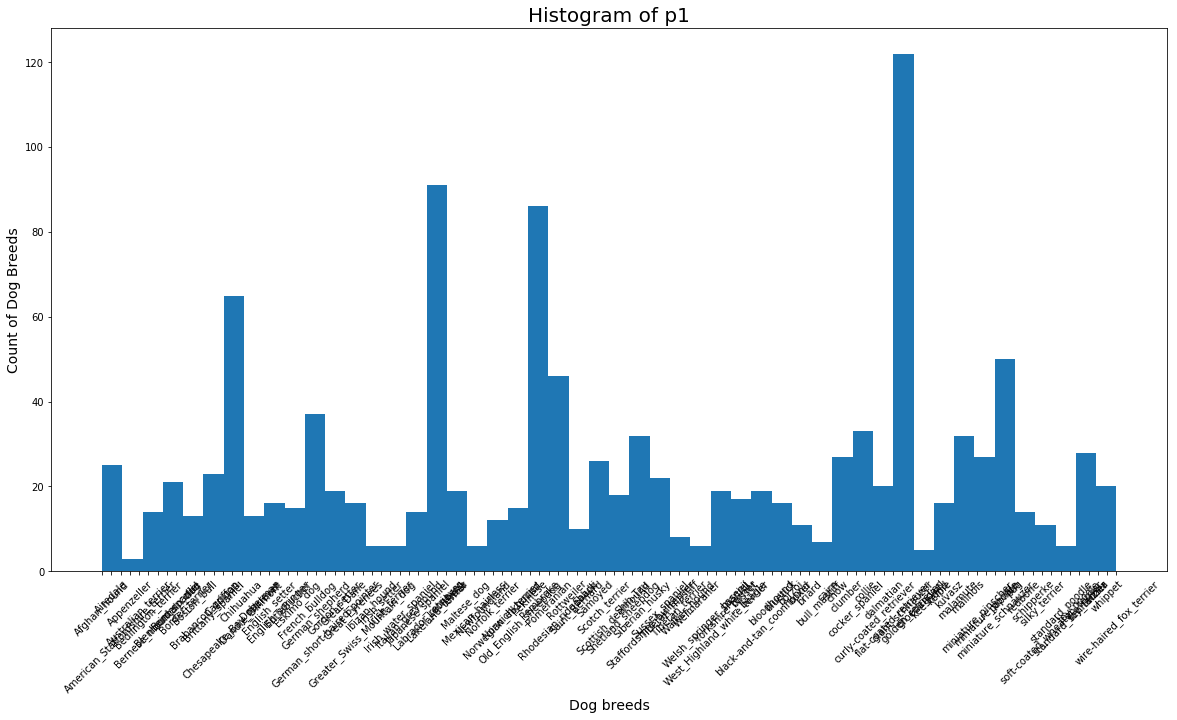

In [116]:
### Histogram of dog breeds

plt.figure(figsize = (20, 10))
plt.title('Histogram of p1', fontsize = 20)
plt.xlabel('Dog breeds', fontsize = 14)
plt.ylabel('Count of Dog Breeds', fontsize = 14)
plt.hist(df_test.p1, bins =50)
plt.xticks(rotation = 45);

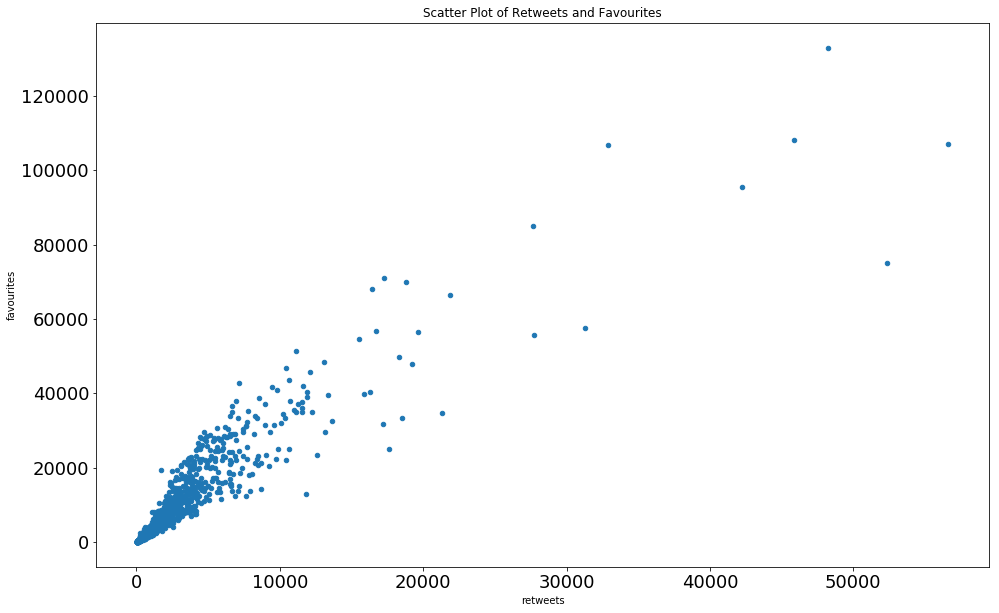

In [117]:
df_test.plot(kind = 'scatter', x = 'retweets', y = 'favourites', figsize = (16, 10), fontsize = 18, title = 'Scatter Plot of Retweets and Favourites');

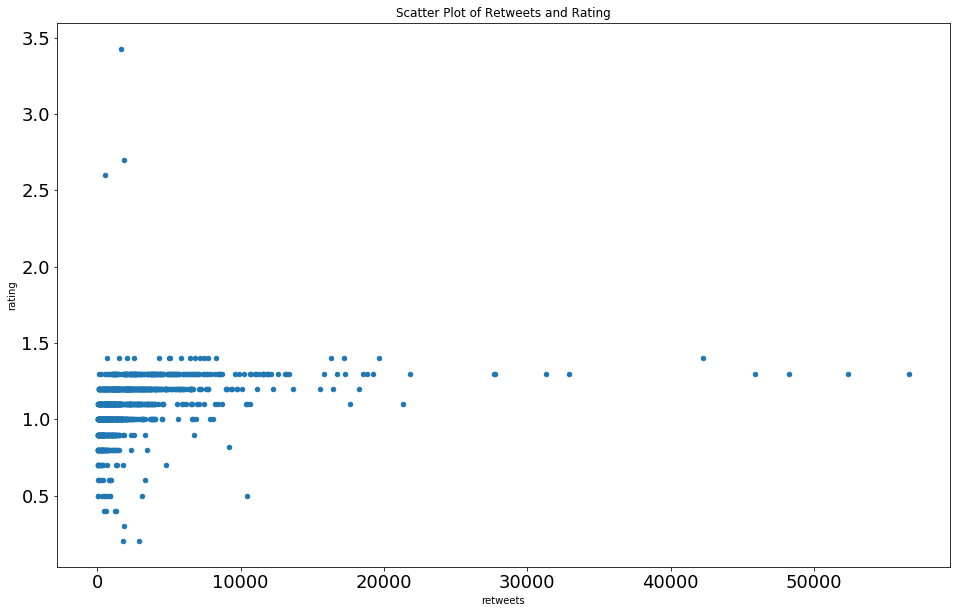

In [118]:
df_test.plot(kind = 'scatter', x = 'retweets', y = 'rating', figsize = (16, 10), fontsize = 18, title = 'Scatter Plot of Retweets and Rating');